# totalVI Tutorial

totalVI is an end-to-end framework for CITE-seq data. With totalVI, we can produce a joint latent representation of cells, denoised data for both protein and RNA, and integrate datasets. We also show how to use totalVI for differential expression testing of genes and proteins. Here we demonstrate this functionality with an integrated analysis of PBMC10k and PBMC5k, datasets of peripheral blood mononuclear cells publicly available from 10X Genomics subset to the 14 shared proteins between them. The same pipeline would generally be used to analyze a single CITE-seq dataset.



In [ ]:
# If running in Colab, navigate to Runtime -> Change runtime type
# and ensure you're using a Python 3 runtime with GPU hardware accelerator
# installation in Colab can take several minutes

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yoseflab/scvi/blob/stable/tests/notebooks/totalVI.ipynb)

In [2]:
import sys
IN_COLAB = "google.colab" in sys.modules

def allow_notebook_for_test():
    print("Testing the totalVI notebook")

show_plot = True
test_mode = False
save_path = "data/"

if not test_mode:
    save_path = "../../data"

if IN_COLAB:
    !pip install --quiet git+https://github.com/yoseflab/scvi@stable#egg=scvi[notebooks]

     |████████████████████████████████| 51kB 3.1MB/s 
     |████████████████████████████████| 112kB 9.8MB/s 
     |████████████████████████████████| 102kB 10.9MB/s 
     |████████████████████████████████| 7.2MB 29.9MB/s 
     |████████████████████████████████| 9.2MB 5.8MB/s 
     |████████████████████████████████| 92kB 10.4MB/s 
     |████████████████████████████████| 2.4MB 36.6MB/s 
     |████████████████████████████████| 3.2MB 31.6MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 


## Imports and data loading

In [3]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import anndata
import os

from scvi.dataset import GeneExpressionDataset, DownloadableAnnDataset
from scvi.models import TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer
from scvi import set_seed

if IN_COLAB:
    %matplotlib inline

# Sets the random seed for torch and numpy
set_seed(0)

sc.set_figure_params(figsize=(4, 4))

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


This dataset was filtered as described in the totalVI manuscript (low quality cells, doublets, lowly expressed genes, etc.)

In [4]:
dataset1 = DownloadableAnnDataset(
    "pbmc_10k_protein.h5ad", 
    save_path=save_path, 
    url="https://github.com/YosefLab/scVI-data/raw/master/pbmc_10k_protein_v3.h5ad?raw=true",
    cell_measurements_col_mappings={"protein_expression":"protein_names"},
)

dataset2 = DownloadableAnnDataset(
    "pbmc_5k_protein.h5ad", 
    save_path=save_path, 
    url="https://github.com/YosefLab/scVI-data/raw/master/pbmc_5k_protein_v3.h5ad?raw=true",
    cell_measurements_col_mappings={"protein_expression":"protein_names"},
)

[2020-04-28 00:33:02,528] INFO - scvi.dataset.dataset | Downloading file at /data/pbmc_10k_protein.h5ad
[2020-04-28 00:33:04,914] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-28 00:33:04,915] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-28 00:33:09,083] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-28 00:33:09,258] INFO - scvi.dataset.dataset | Downsampled from 6855 to 6855 cells
[2020-04-28 00:33:09,828] INFO - scvi.dataset.dataset | Downloading file at /data/pbmc_5k_protein.h5ad
[2020-04-28 00:33:10,990] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-28 00:33:10,992] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-28 00:33:13,260] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-28 00:33:13,359] INFO - scvi.dataset.dataset | Downsampled from 3994 to 3994 cells


Alternatively, to load from a local AnnData object with `"protein_expression"` `obsm` and `"protein_names"` `uns`

```
from scvi.dataset import AnnDatasetFromAnnData, CellMeasurement

anndataset = anndata.read(save_path + "filename.h5ad")
dataset = AnnDatasetFromAnnData(
    ad=anndataset,
    cell_measurements_col_mappings={"protein_expression":"protein_names"},
)
```

In general, protein data can be added to any `GeneExpressionDataset` through the `.initialize_cell_measurement(.)` method as shown below.

```
from scvi.dataset import CellMeasurement
dataset = ... # scVI dataset object
protein_data = CellMeasurement(
    name="protein_expression",
    data=protein_data # cells by proteins numpy.ndarray,
    columns_attr_name="protein_names",
    columns=protein_names # 1d array of protein names,
)
dataset.initialize_cell_measurement(protein_data)
```

Now we concatenate the datasets and subsample to 4000 genes, which by default uses the Seurat v3 VST method

In [5]:
# concatenate the datasets
dataset = GeneExpressionDataset()
dataset.populate_from_datasets([dataset1, dataset2])
dataset.subsample_genes(4000)

[2020-04-28 00:33:13,371] INFO - scvi.dataset.dataset | Merging datasets. Input objects are modified in place.
[2020-04-28 00:33:13,372] INFO - scvi.dataset.dataset | Gene names and cell measurement names are assumed to have a non-null intersection between datasets.
[2020-04-28 00:33:13,407] INFO - scvi.dataset.dataset | Keeping 15792 genes
[2020-04-28 00:33:17,495] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-28 00:33:18,027] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-28 00:33:18,029] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-28 00:33:20,345] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-28 00:33:20,651] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-28 00:33:20,653] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-28 00:33:21,955] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-28 00:33:21,957] INFO - 

Transforming to str index.


[2020-04-28 00:33:25,519] INFO - scvi.dataset.dataset | Downsampling from 15792 to 4000 genes
[2020-04-28 00:33:27,227] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-28 00:33:27,427] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-04-28 00:33:29,064] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-28 00:33:29,137] INFO - scvi.dataset.dataset | Downsampled from 10849 to 10849 cells


## Prepare and run model

Notice that the dataset has two batches in it. We input the number of batches to the totalVI model. If we would not like to perform batch correction, we can leave `n_batch = 0` when instantiating the `TOTALVI` model class -- which is also the default. Setting this parameter alerts totalVI to input the batch information in the encoder and decoder.

In [6]:
print(dataset.n_batches)

2


In [ ]:
totalvae = TOTALVI(
    dataset.nb_genes, 
    len(dataset.protein_names), 
    n_batch=dataset.n_batches,
)
use_cuda = True
lr = 4e-3
n_epochs = 500

# totalVI is trained on 90% of the data
# Early stopping does not comply with our automatic notebook testing so we disable it when testing
trainer = TotalTrainer(
    totalvae,
    dataset,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=1,
    batch_size=256,
    early_stopping_kwargs="auto" if not test_mode else None
)

In [8]:
trainer.train(lr=lr, n_epochs=n_epochs)

[2020-04-28 00:33:39,187] INFO - scvi.inference.inference | KL warmup for 8136.75 iterations
training:  98%|█████████▊| 489/500 [13:53<00:18,  1.67s/it][2020-04-28 00:47:34,112] INFO - scvi.inference.trainer | 
Stopping early: no improvement of more than 0 nats in 45 epochs
[2020-04-28 00:47:34,113] INFO - scvi.inference.trainer | If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.


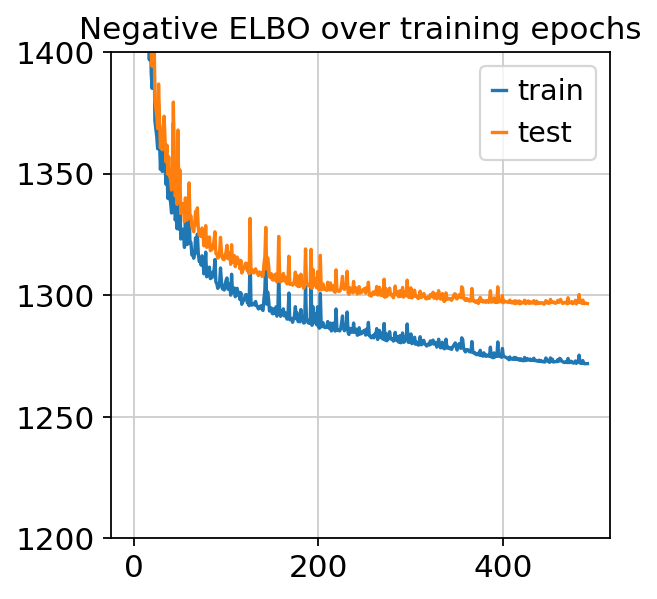

In [9]:
plt.plot(trainer.history["elbo_train_set"], label="train")
plt.plot(trainer.history["elbo_test_set"], label="test")
plt.title("Negative ELBO over training epochs")
plt.ylim(1200, 1400)
plt.legend()

## Analyze outputs

We use scanpy to do clustering, umap, visualization after running totalVI. A posterior object has access to the dataset object, and the model object. It iterates over cells in the dataset and passes them through the model.

In [ ]:
# create posterior on full data
# this by default uses the scVI dataset object and the model used for training
full_posterior = trainer.create_posterior(type_class=TotalPosterior)
full_posterior = full_posterior.update({"batch_size":32})

# extract latent space
latent_mean, batch_index, label, library_gene = full_posterior.get_latent()

# Number of Monte Carlo samples to average over
n_samples = 25
# Probability of background for each (cell, protein)
py_mixing = full_posterior.get_sample_mixing(n_samples=n_samples, give_mean=True, transform_batch=[0, 1])
parsed_protein_names = [p.split("_")[0] for p in dataset.protein_names]
protein_foreground_prob = pd.DataFrame(
    data=(1 - py_mixing), columns=parsed_protein_names
)

denoised_genes, denoised_proteins = full_posterior.get_normalized_denoised_expression(
    n_samples=n_samples, give_mean=True, transform_batch=[0, 1]
)

### Construct posterior anndata objects

Here we make anndata objects to store the outputs of totalVI.

We make a separate object for RNA and proteins. These objects can be saved and then reopened in an R based pipeline.

In [ ]:
post_adata = anndata.AnnData(X=dataset.X)
post_adata.var_names = dataset.gene_names
# put the denoised genes in the adata object
post_adata.raw = post_adata
post_adata.X = denoised_genes


We can use the RNA object and scanpy to get clusters and visualization of the latent space.

In [ ]:
post_adata.obsm["X_totalVI"] = latent_mean
sc.pp.neighbors(post_adata, use_rep="X_totalVI", n_neighbors=25, metric="correlation")
sc.tl.umap(post_adata, min_dist=0.4)
sc.tl.leiden(post_adata, key_added="leiden_totalVI", resolution=0.7)

Now the protein adata

In [ ]:
pro_adata = anndata.AnnData(np.log1p(dataset.protein_expression))
pro_adata.var_names = dataset.protein_names
pro_adata.raw = pro_adata
pro_adata.X = denoised_proteins
pro_adata.obs["leiden_totalVI"] = post_adata.obs["leiden_totalVI"]
# these are cleaner protein names ("_TotalSeqB" removed)
pro_adata.var["protein_names"] = [p.split("_")[0] for p in pro_adata.var_names]
pro_adata.obsm["X_umap"] = post_adata.obsm["X_umap"]

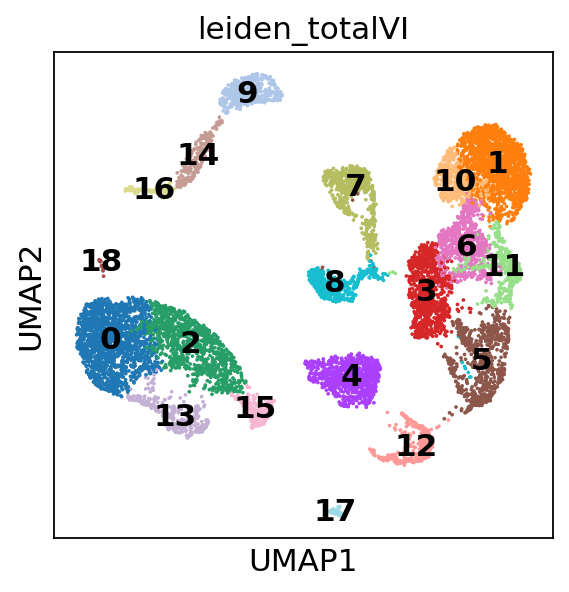

Trying to set attribute `.uns` of view, copying.


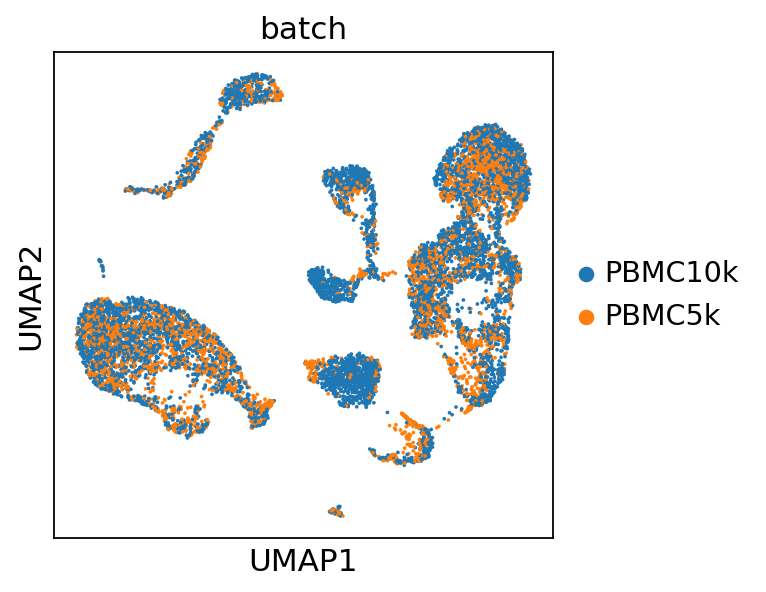

In [14]:
dataset_names = np.array(["PBMC10k", "PBMC5k"])
post_adata.obs["batch"] = pd.Categorical(dataset_names[dataset.batch_indices.ravel()])
perm_inds = np.random.permutation(len(post_adata))

sc.pl.umap(
    post_adata, 
    color=["leiden_totalVI"], 
    show=show_plot,
    legend_loc="on data",
)
sc.pl.umap(
    post_adata[perm_inds], 
    color=["batch"], 
    show=show_plot,
)

In [ ]:
for i, p in enumerate(parsed_protein_names):
    pro_adata.obs["{}_fore_prob".format(p)] = protein_foreground_prob[p].values

### Visualize denoised protein values 

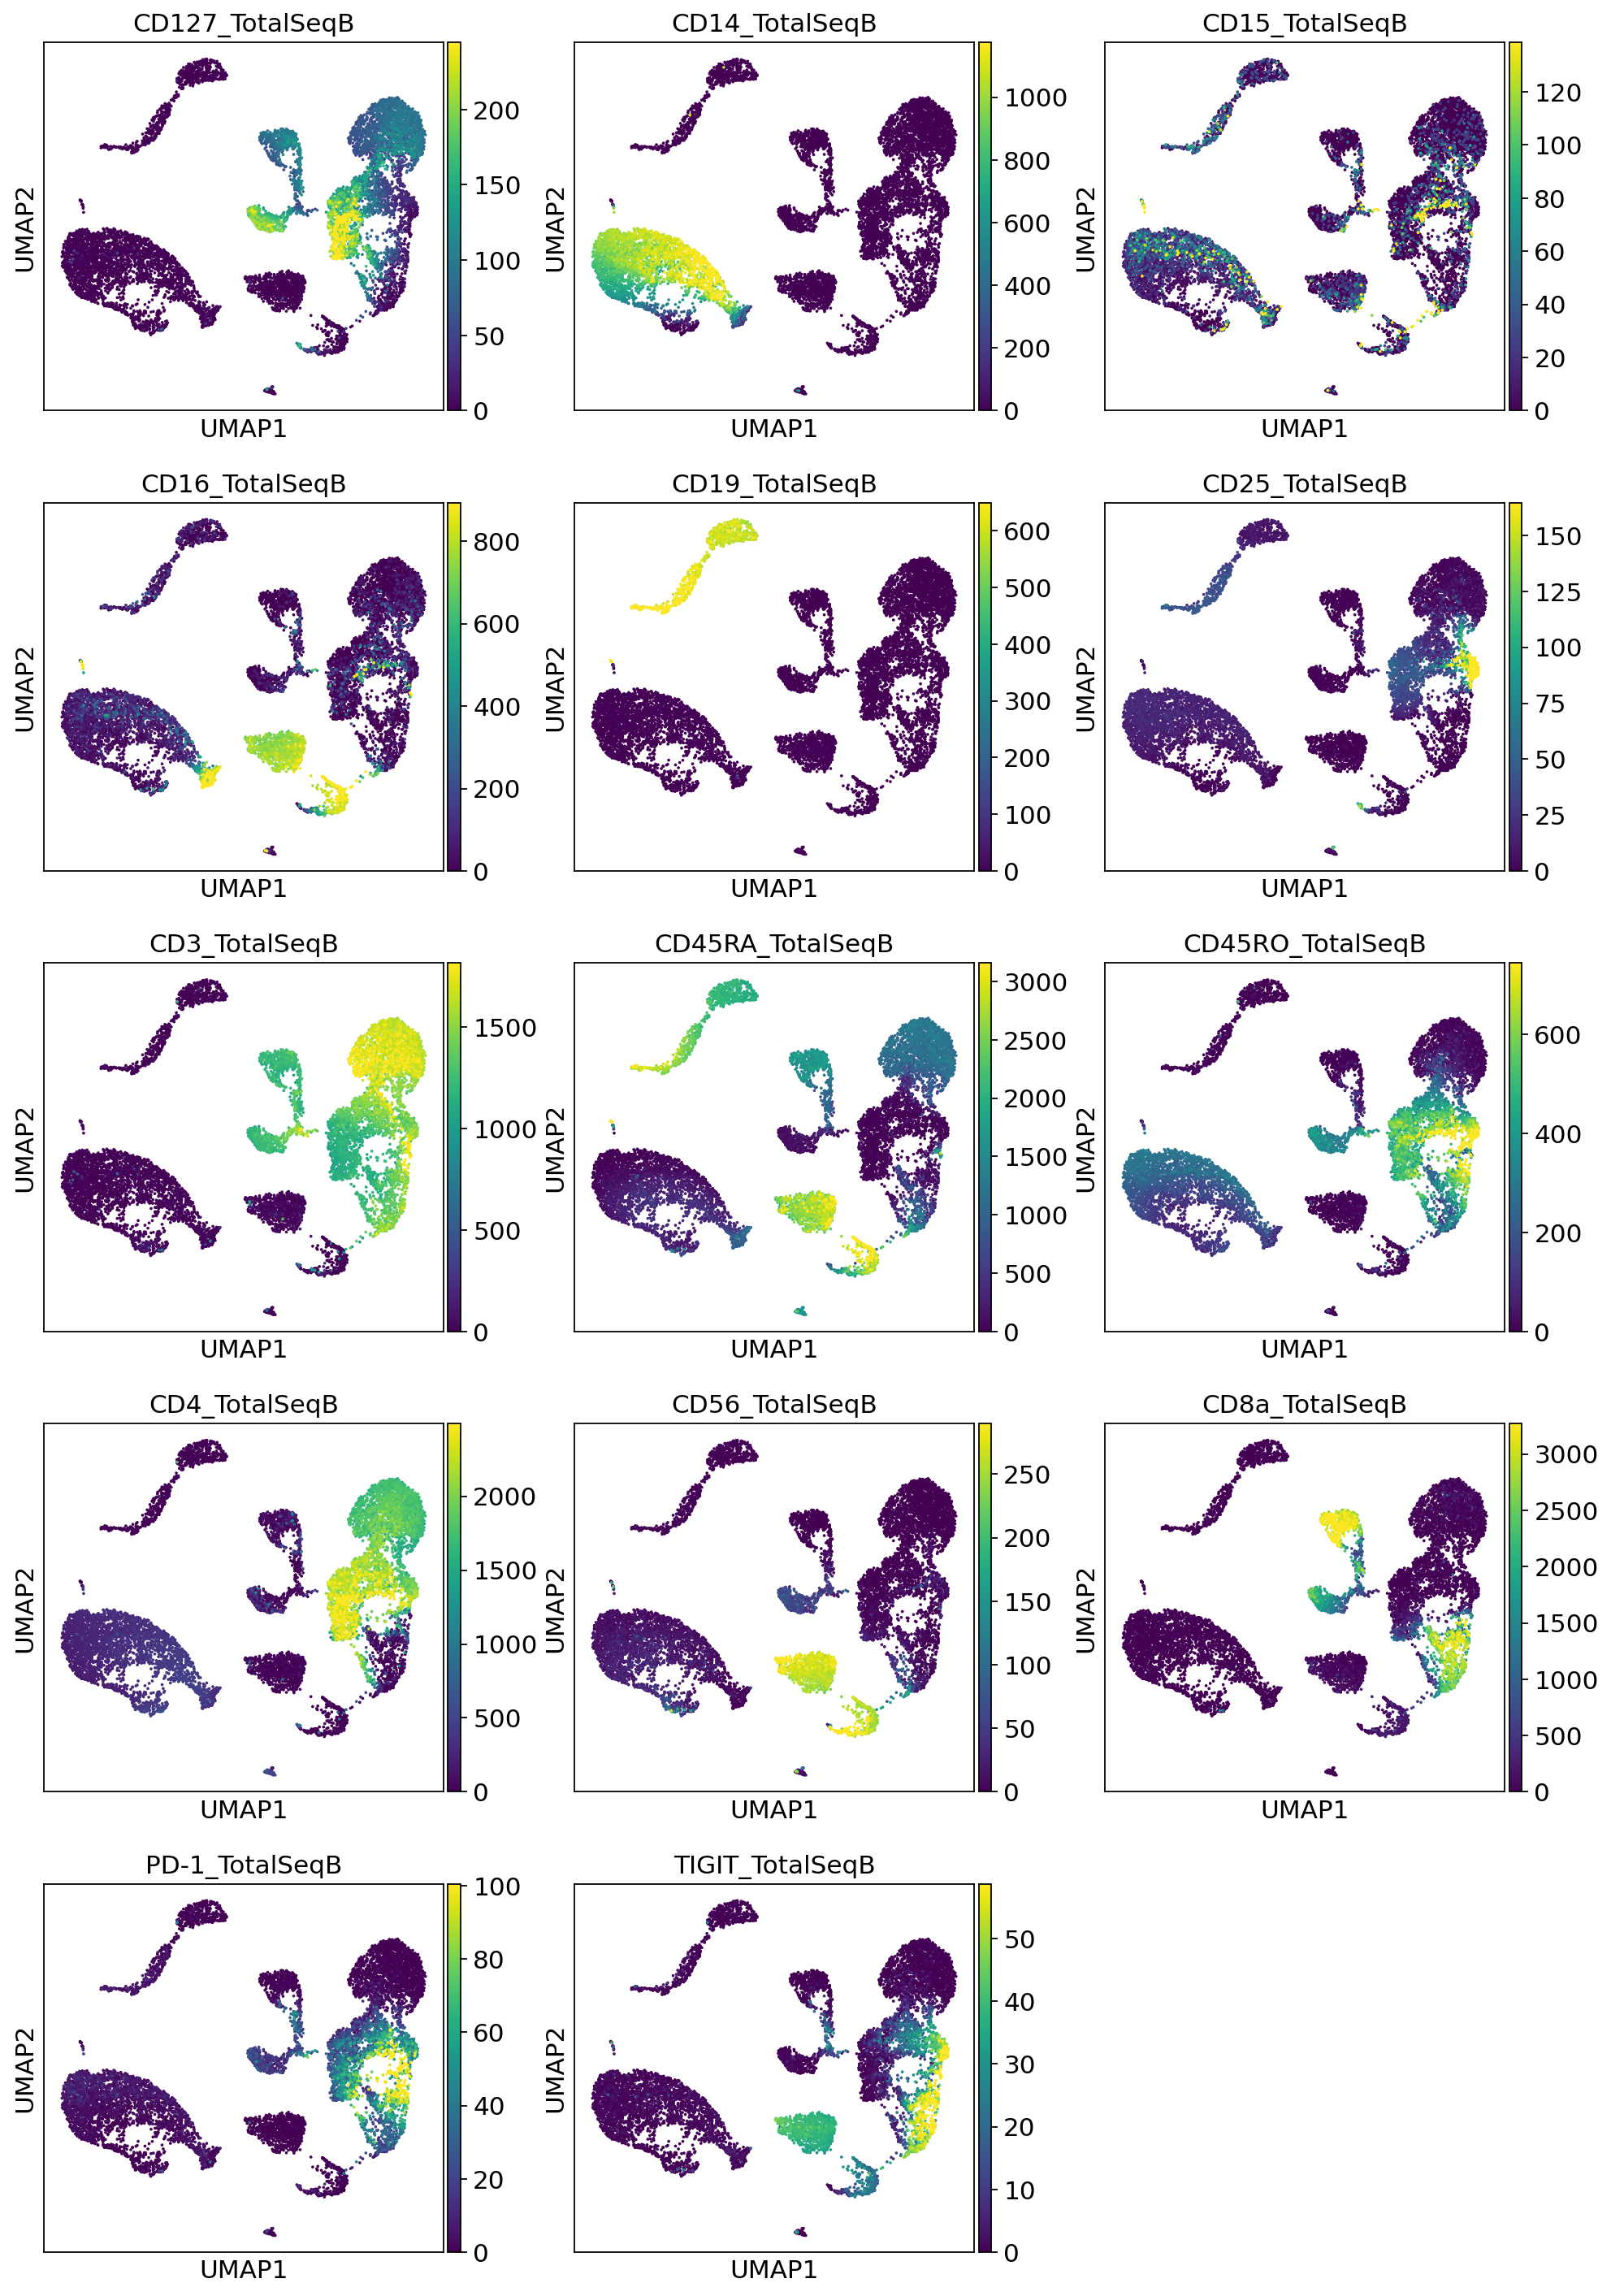

In [16]:
sc.pl.umap(
    pro_adata, 
    color=pro_adata.var_names,
    gene_symbols="protein_names",
    ncols=3, 
    show=show_plot,
    vmax="p99",
    use_raw=False
)

### Visualize probability of foreground

Here we visualize the probability of foreground for each protein and cell (projected on UMAP).
Some proteins are easier to disentangle than others. Some proteins end up being "all background".
For example, CD15 does not appear to be captured well, when looking at the denoised values above we see little localization in the monocytes.

<div class="alert alert-info">

Note

While the foreground probability could theoretically be used to identify cell populations, we recommend using the denoised protein expression, which accounts for the foreground/background probability, but preserves the dynamic range of the protein measurements. Consequently, the denoised values are on the same scale as the raw data and it may be desirable to take a transformation like log or square root.

</div>

By viewing the foreground probability, we can get a feel for the types of cells in our dataset. For example, it's very easy to see a population of monocytes based on the CD14 foregroud probability.

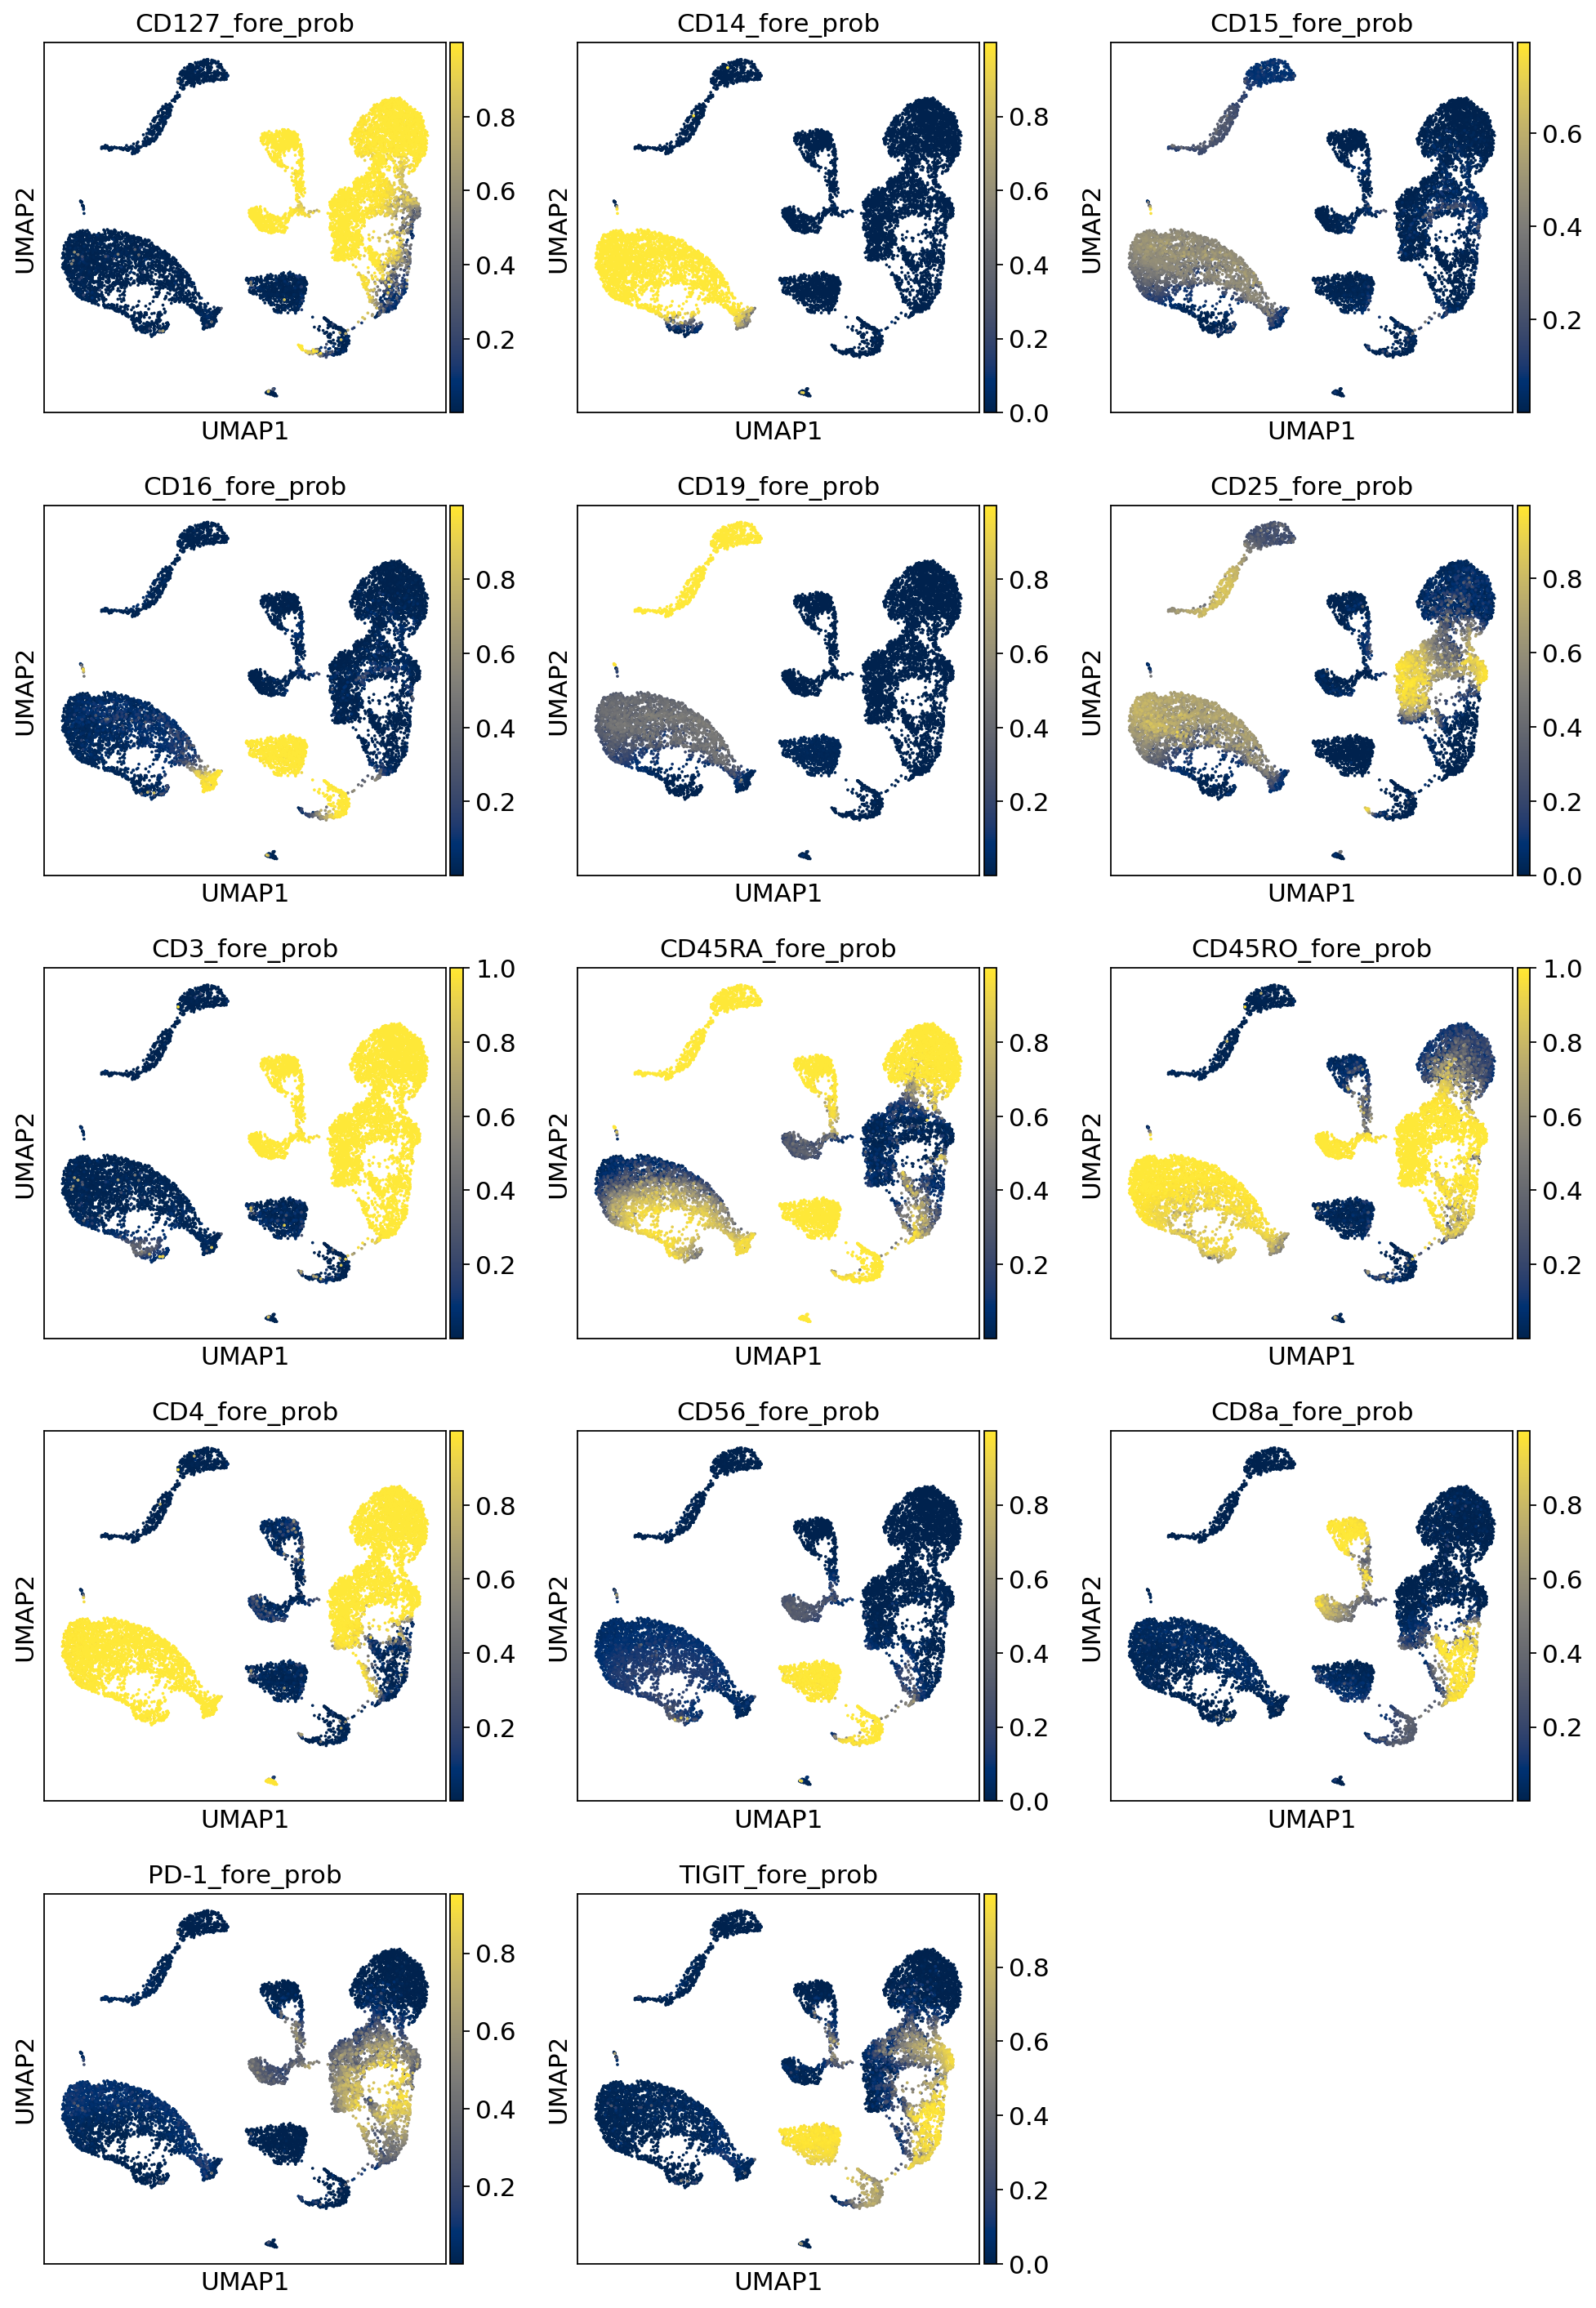

In [17]:
sc.pl.umap(
    pro_adata,
    color=["{}_fore_prob".format(p) for p in parsed_protein_names],
    ncols=3,
    show=show_plot,
    color_map="cividis"
)

## Differential expression

Here we do a one-vs-all DE test, where each cluster is tested against all cells not in that cluster

In [18]:
# get the cluster IDs as ints
scanpy_labels = post_adata.obs.leiden_totalVI.to_numpy(dtype=int)

per_cluster_de, cluster_id = full_posterior.one_vs_all_degenes(
    cell_labels=scanpy_labels,
    min_cells=1,
    n_samples=5000,
    use_permutation=False,
    mode="change",
    delta=0.2
)

`per_cluster_de` is a list of DataFrames, with length number of clusters in `scanpy_labels`. `cluster_id` is a list of the same length indicating the cluster used in the one-vs-all test.

In [19]:
print(len(per_cluster_de))
print(cluster_id)

19
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


This would be the test of cluster 0 versus all other cells. Both genes and proteins are included in these DataFrames.

In [20]:
per_cluster_de[0].head(10)

proba_de  proba_not_de  ...  raw_normalized_mean2  clusters
SERPINB2     0.9978        0.0022  ...              0.000329         0
HP           0.9972        0.0028  ...              0.001776         0
SERPINB10    0.9956        0.0044  ...              0.001190         0
LGALS12      0.9950        0.0050  ...              0.006073         0
CYP1B1       0.9948        0.0052  ...              0.118418         0
MARC1        0.9944        0.0056  ...              0.030529         0
MCEMP1       0.9942        0.0058  ...              0.033136         0
S100A12      0.9940        0.0060  ...              0.898923         0
ORM1         0.9936        0.0064  ...              0.000531         0
CABP4        0.9934        0.0066  ...              0.094801         0

[10 rows x 17 columns]

Now we filter the results such that we retain features above a certain Bayes factor (which here is on the natural log scale) and genes with greater than 10% non-zero entries in the cluster of interest.

In [ ]:
filtered_pro = []
filtered_rna = []
for i, cid in enumerate(cluster_id):
    pcd = per_cluster_de[i].sort_values("lfc_median", ascending=False)

    pcd = pcd[pcd.lfc_median > 0]

    pro_rows = pcd.index.str.contains('TotalSeqB')
    data_pro = pcd.iloc[pro_rows]
    data_pro = data_pro[data_pro["bayes_factor"] > 0.7]

    data_rna = pcd.iloc[~pro_rows]
    data_rna = data_rna[data_rna["bayes_factor"] > 0.7]
    data_rna = data_rna[data_rna["non_zeros_proportion1"] > 0.1]

    filtered_pro.append(data_pro)
    filtered_rna.append(data_rna)

In [ ]:
def plot_ranked_features(per_cluster_de_filtered, n_features=10):
    """Code inspired by scanpy pl.rank_genes_groups function (and parts borrowed)
        https://github.com/theislab/scanpy/blob/d47d373e96fed96a40186f258ec81994534fd1cc/scanpy/plotting/_tools/__init__.py#L215-L325
    """

    from matplotlib import gridspec
    from matplotlib import rcParams
    n_panels_x = 4
    n_panels_y = np.ceil(len(cluster_id) / n_panels_x).astype(int)

    fig = plt.figure(figsize=(n_panels_x * rcParams['figure.figsize'][0],
                                n_panels_y * rcParams['figure.figsize'][1]))
    gs = gridspec.GridSpec(nrows=n_panels_y,
                        ncols=n_panels_x,
                        wspace=0.22,
                        hspace=0.3)

    ymin = np.Inf
    ymax = -np.Inf
    for count, df in enumerate(per_cluster_de_filtered):


        ax = fig.add_subplot(gs[count])

        gene_names = df.index
        scores = df["lfc_median"].values
        for ig, g in enumerate(gene_names[:n_features]):
            gene_name = gene_names[ig]
            ax.text(
                ig, scores[ig],
                gene_name,
                rotation='vertical', verticalalignment='bottom',
                horizontalalignment='center', fontsize=11)
            
        if count >= n_panels_x * (n_panels_y - 1):
            ax.set_xlabel('ranking')

        if count % n_panels_x == 0:
            ax.set_ylabel('score')
            
        ax.set_title('{} vs. {}'.format(count, "all"))
        ax.set_xlim(-0.9, ig + 1-0.1)

        if len(scores) > 0:
            ymin = np.min(scores)
            ymax = np.max(scores)
            ymax += 0.3*(np.max(scores)-np.min(scores))
            ax.set_ylim(ymin, ymax)

Now we visualize the top gene and protein markers per test. Here the score is the totalVI log fold change estimate.

For the gene markers:

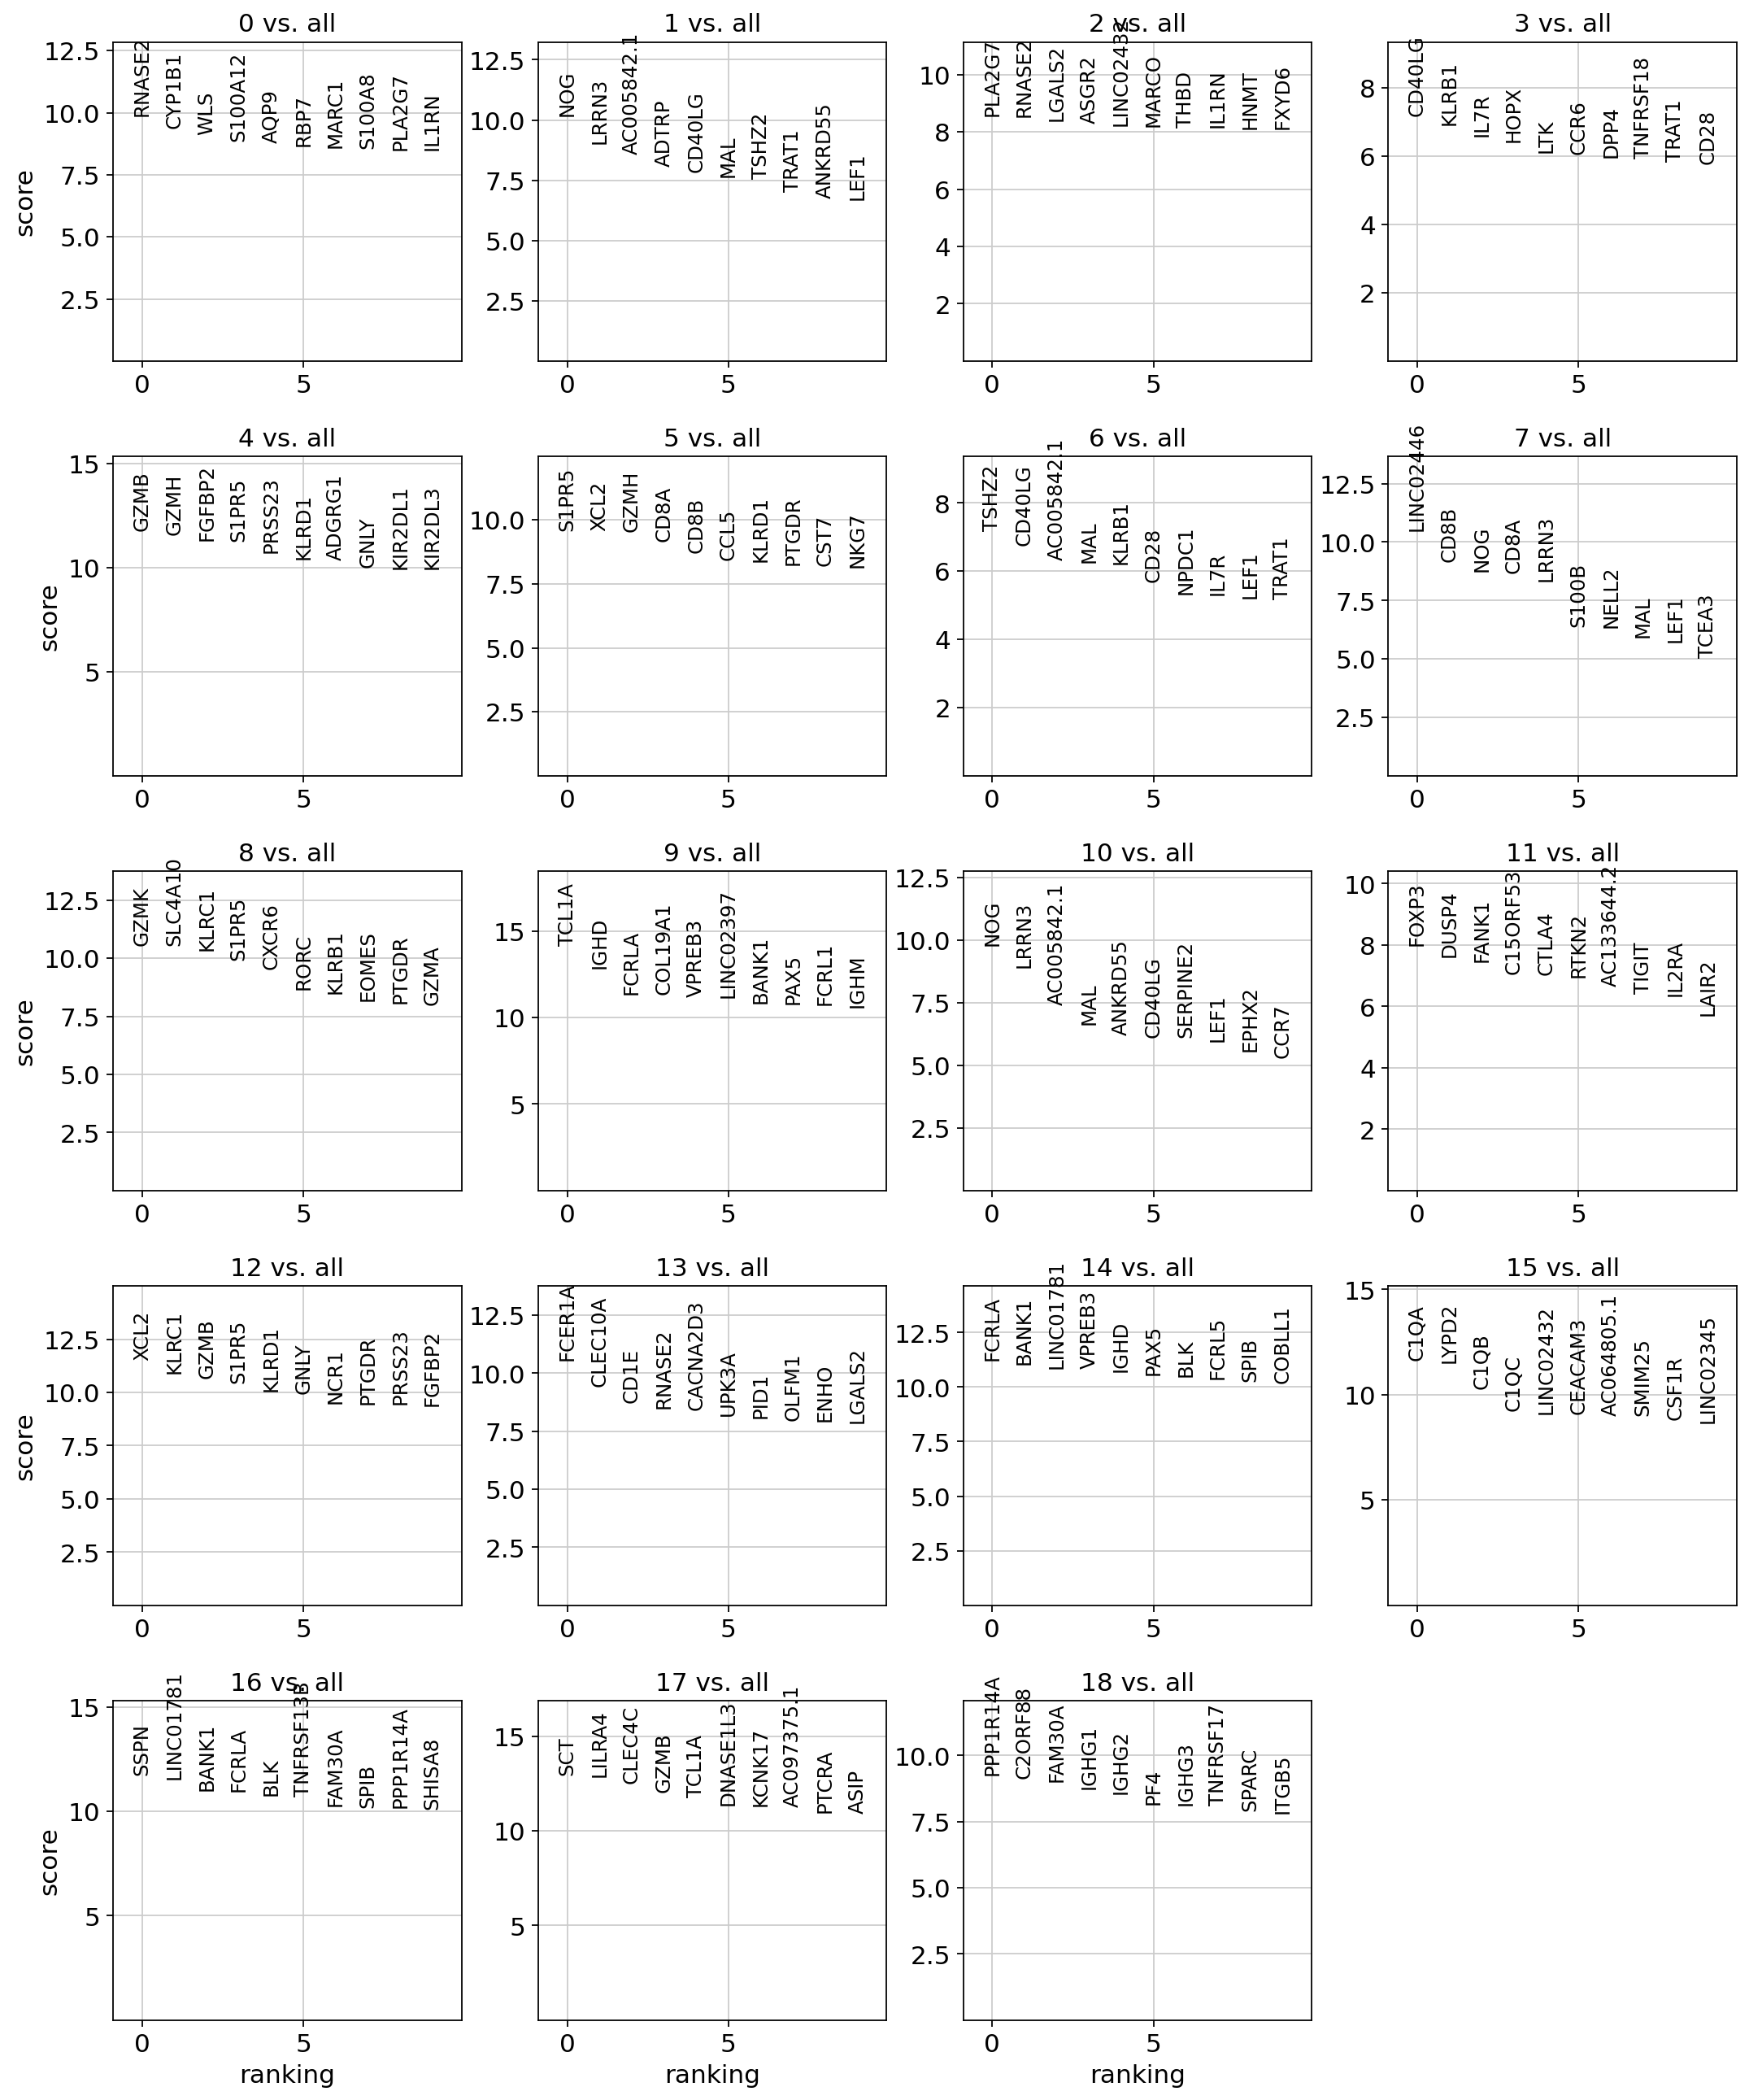

In [23]:
plot_ranked_features(filtered_rna)

and the protein markers:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Attempting to set identical bottom == top == 0.09254598617553711 results in singular transformations; automatically expanding.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Attempting to set identical bottom == top == 1.2862310409545898 results in singular transformations; automatically expanding.


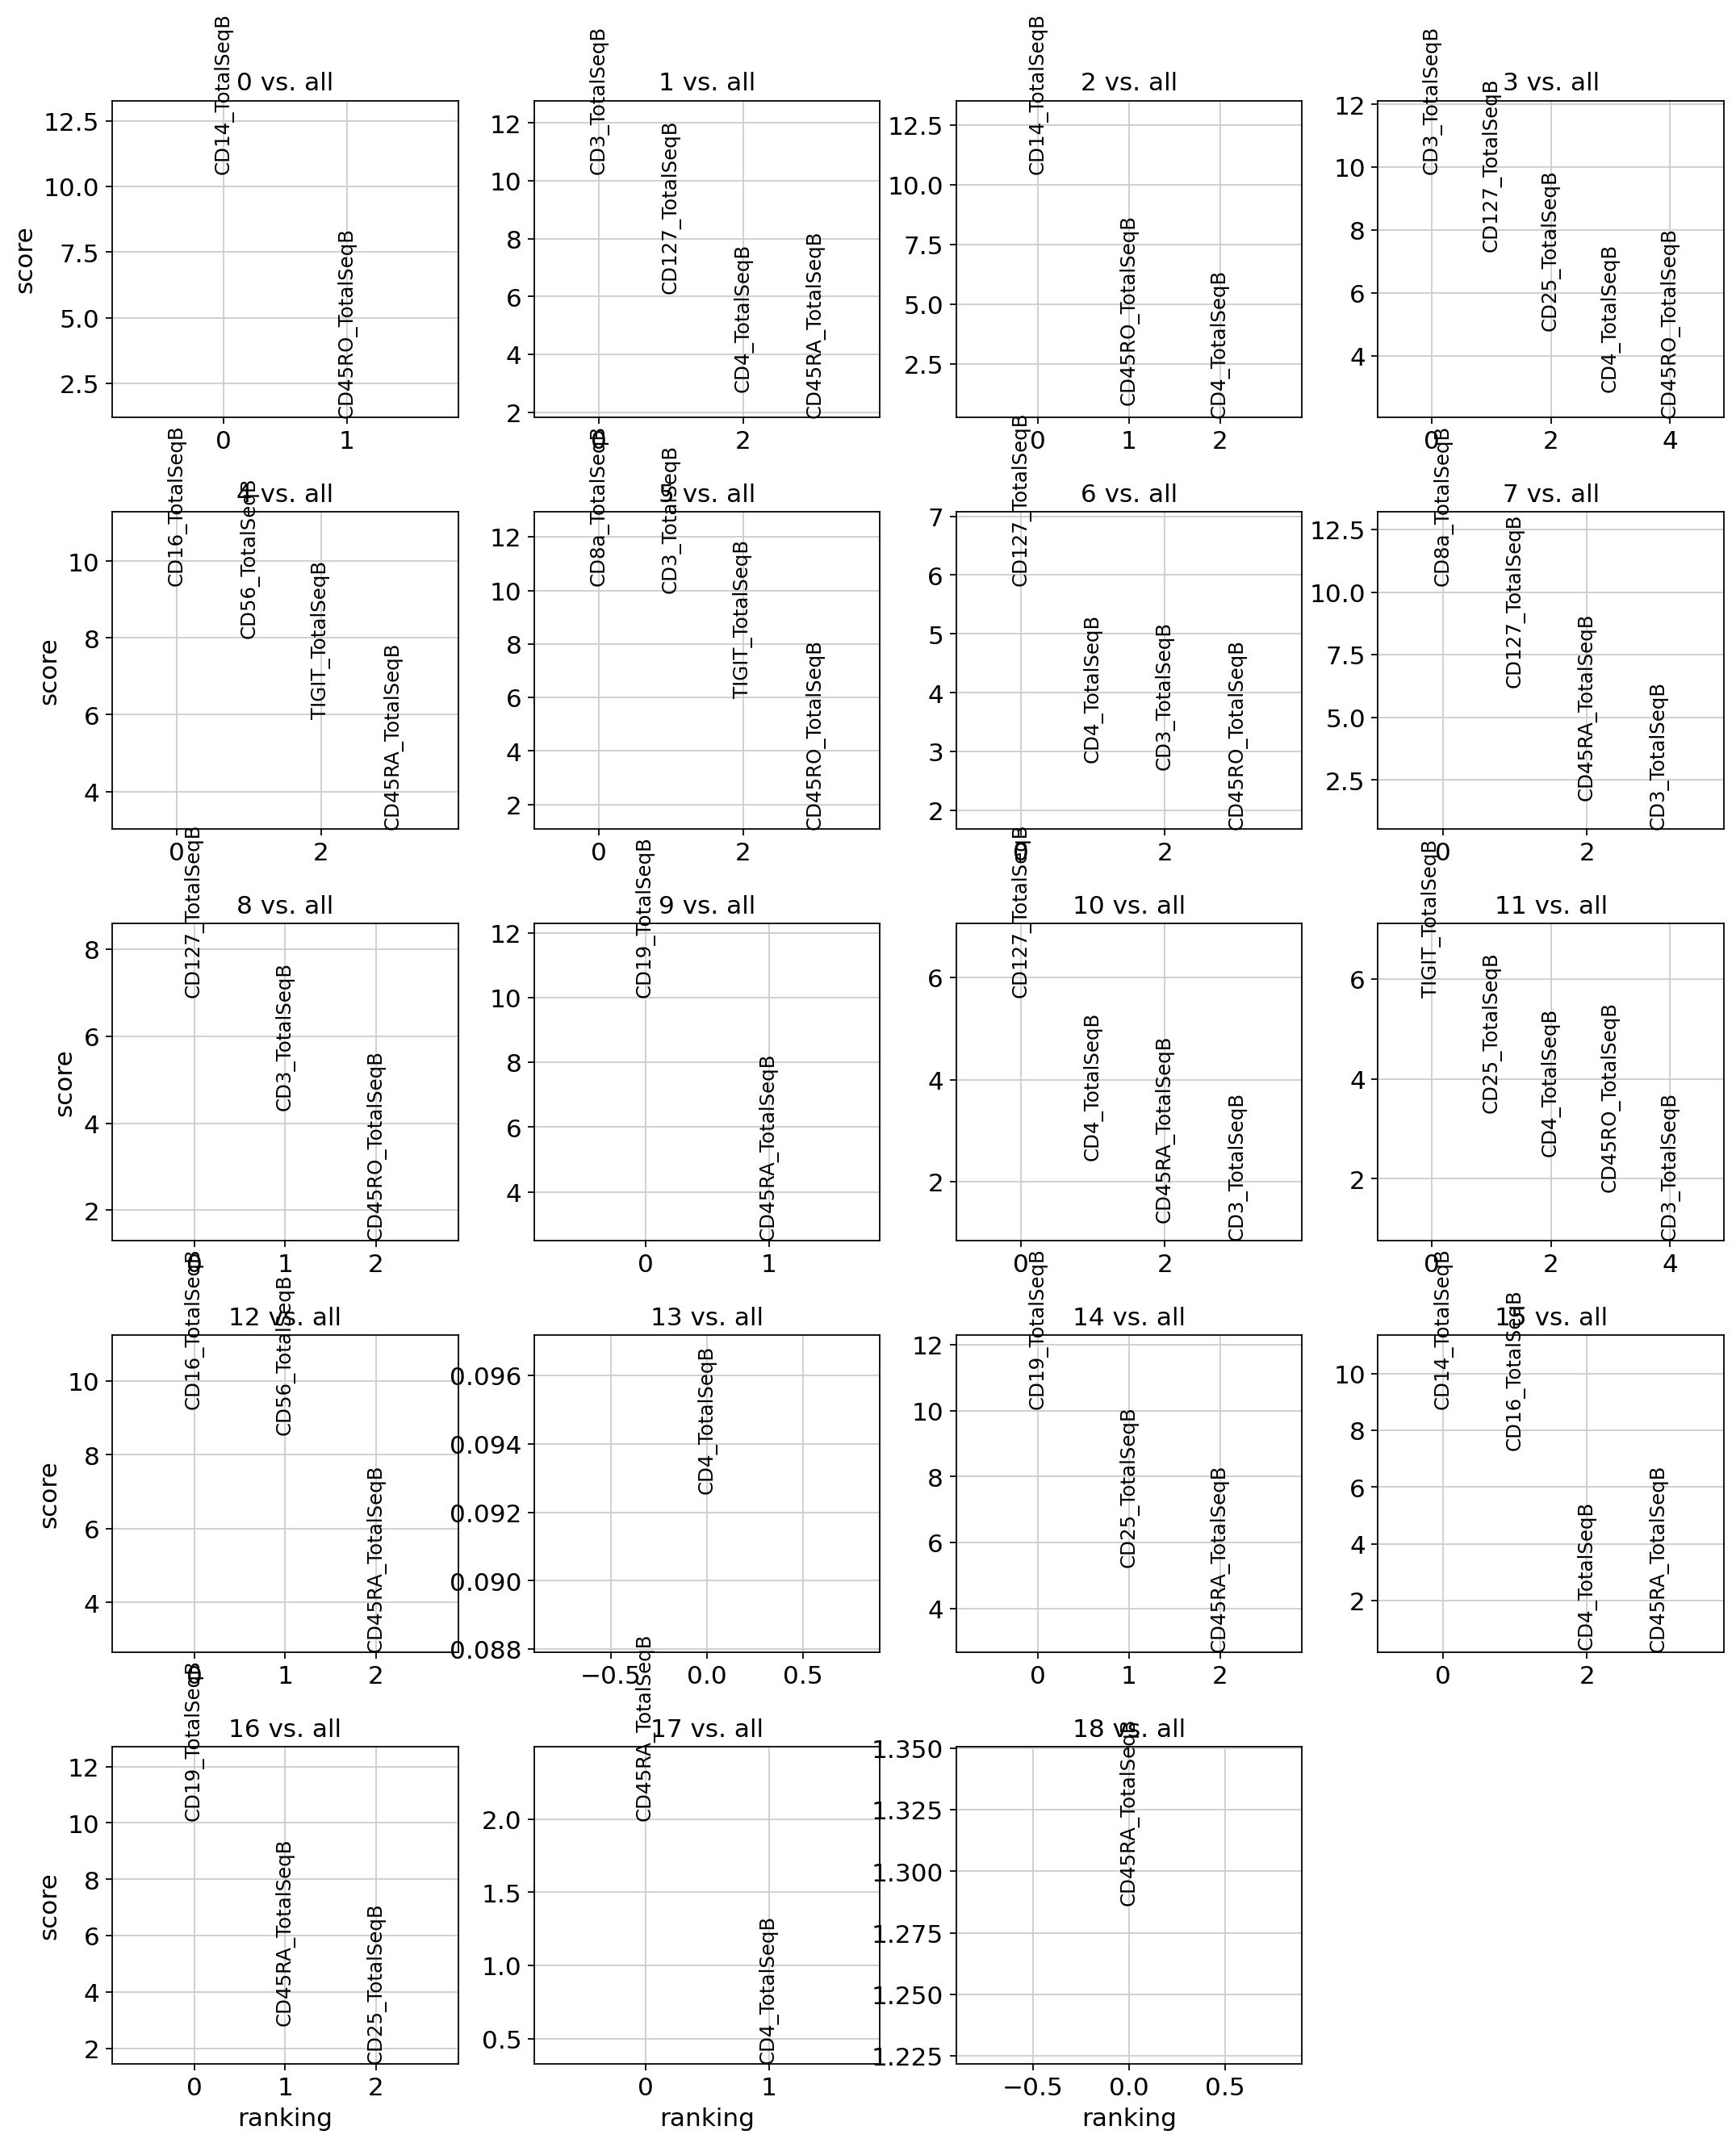

In [24]:
plot_ranked_features(filtered_pro)

We can also use general scanpy visualization functions

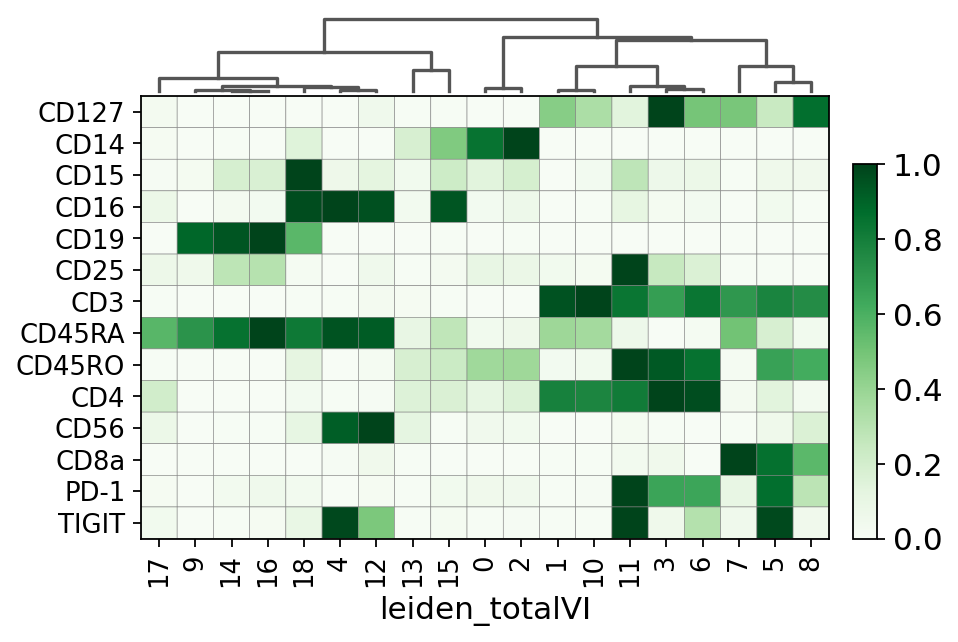

GridSpec(2, 3, height_ratios=[0.5, 2.8000000000000003], width_ratios=[5.7, 0, 0.2])

In [25]:
sc.pl.matrixplot(
    pro_adata,
    pro_adata.var["protein_names"],
    groupby="leiden_totalVI",
    gene_symbols="protein_names",
    dendrogram=True,
    swap_axes=True,
    use_raw=False,
    cmap="Greens",
    standard_scale="var"
)

This is a selection of some of the markers that turned up in the RNA DE test. 

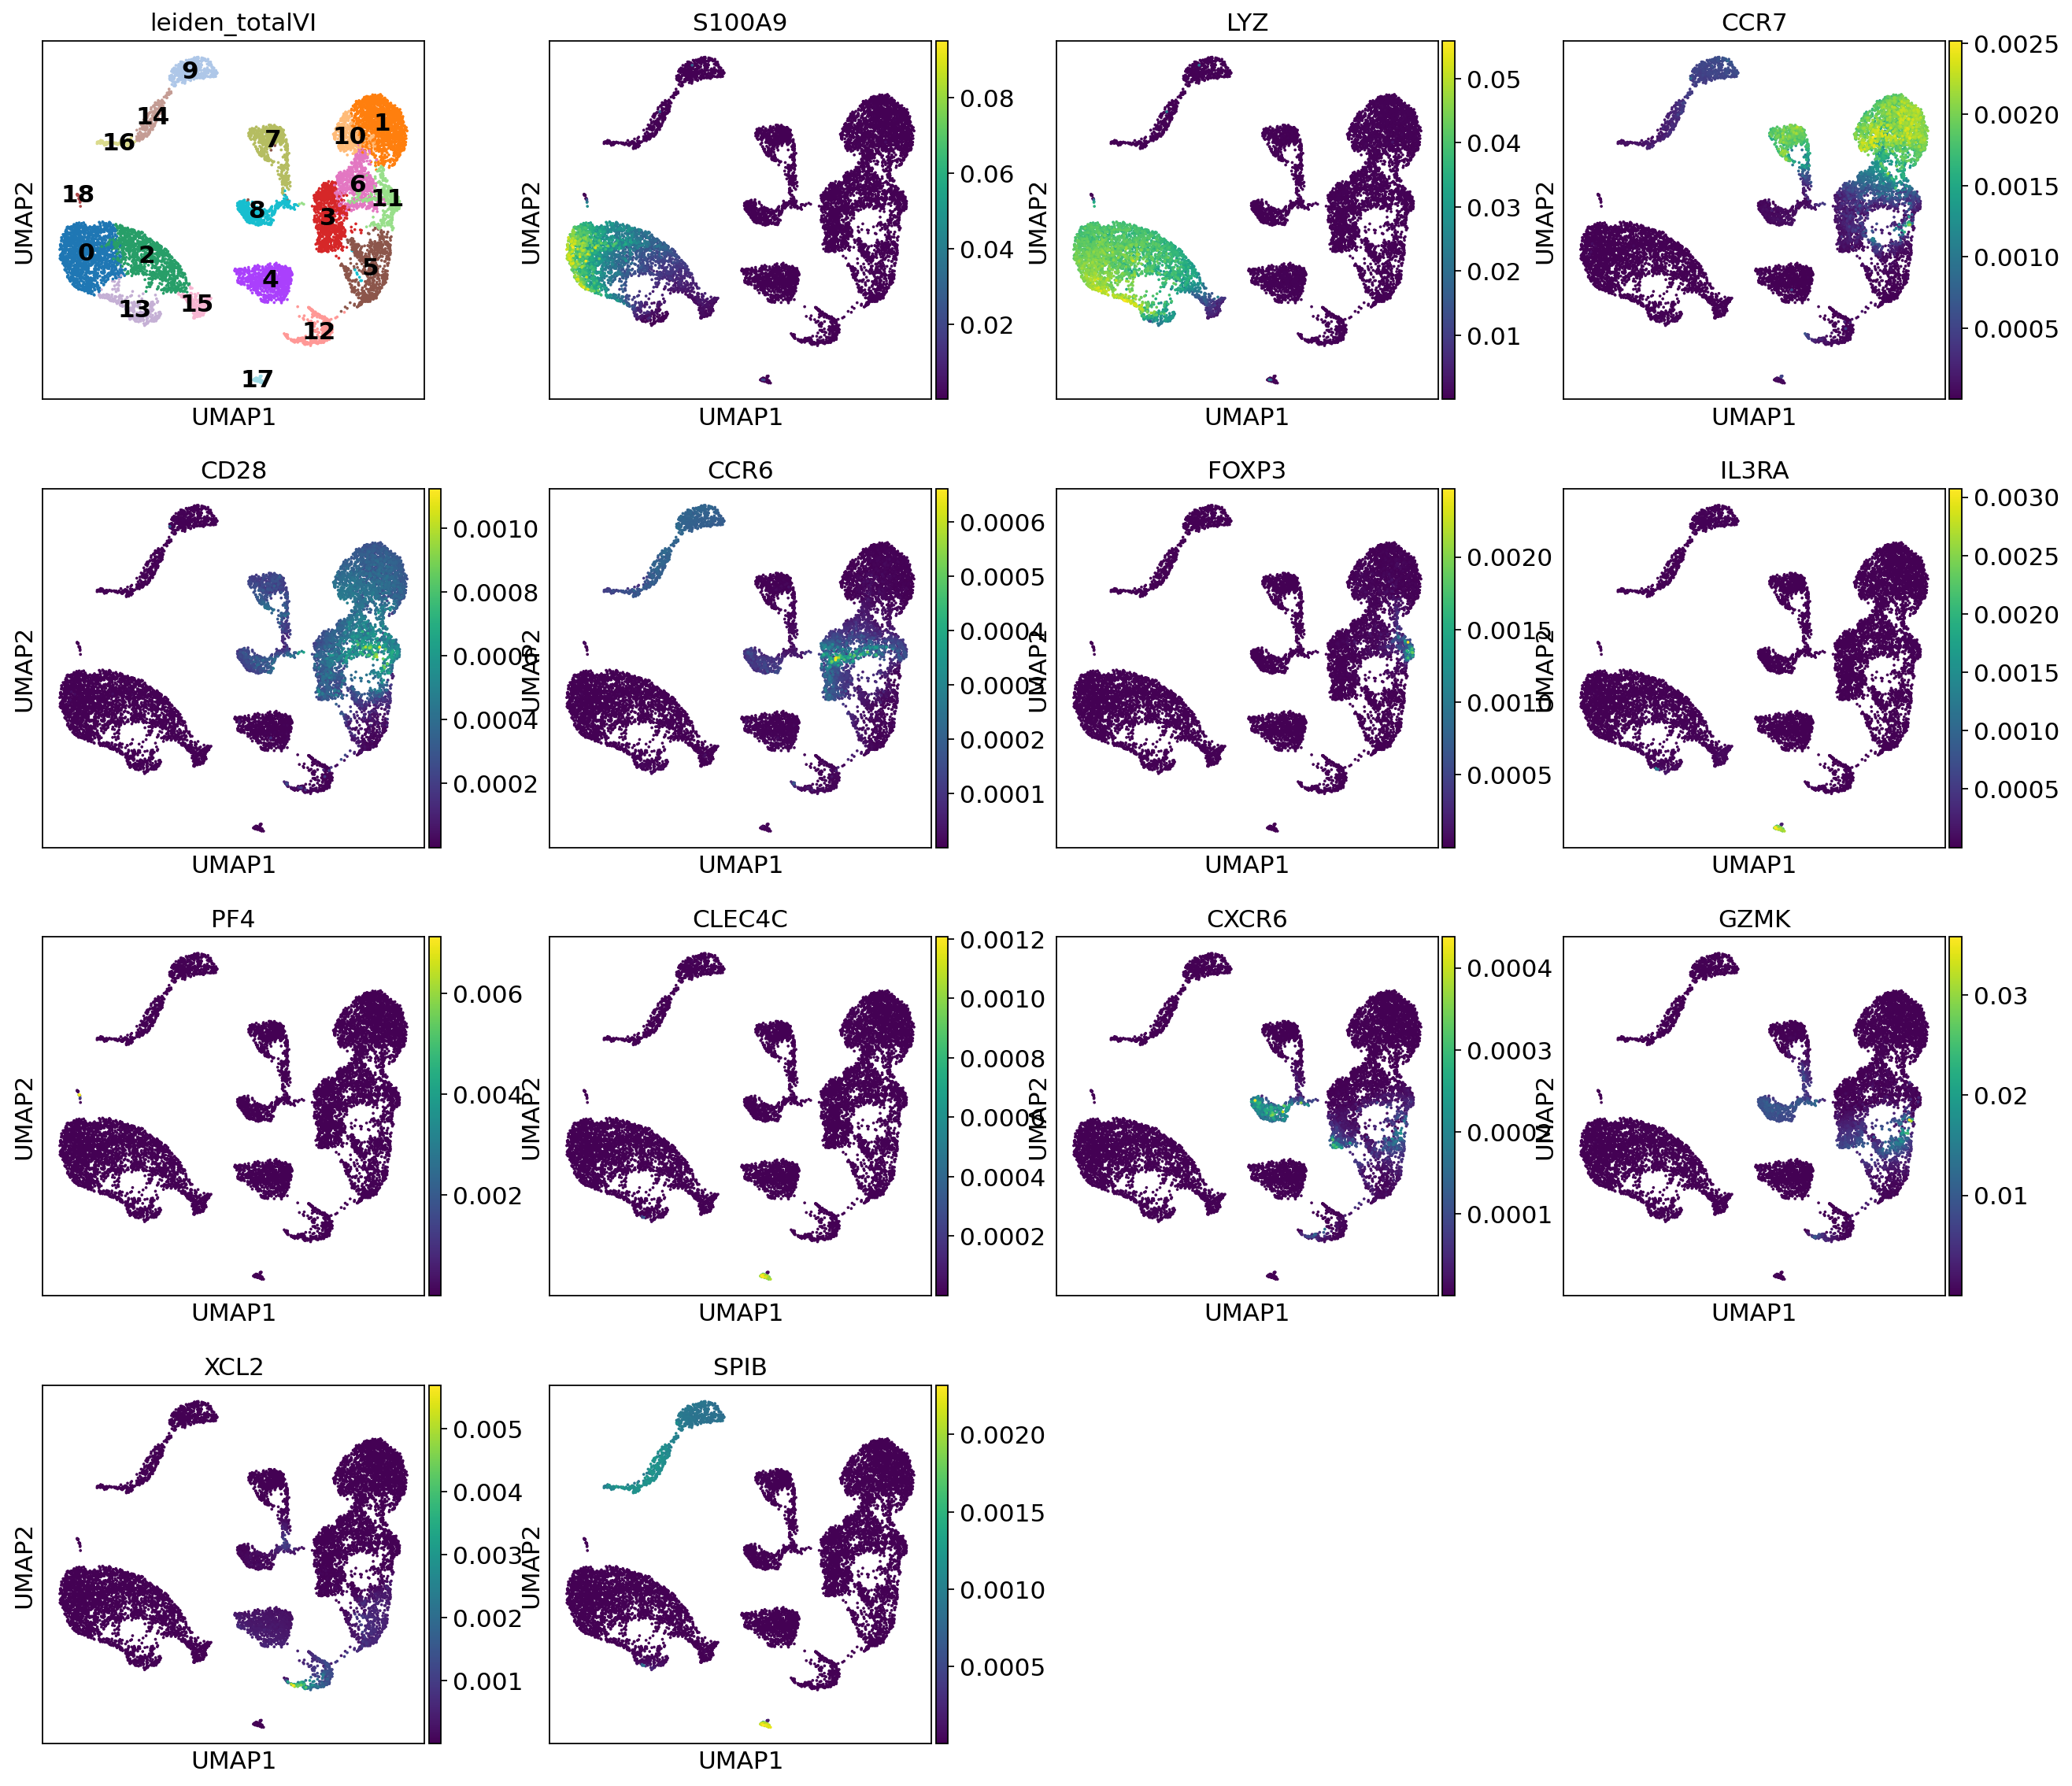

In [26]:
sc.pl.umap(
    post_adata, 
    color=["leiden_totalVI", "S100A9", "LYZ", "CCR7", "CD28", "CCR6", "FOXP3", "IL3RA", "PF4", "CLEC4C", "CXCR6", "GZMK", "XCL2", "SPIB"], 
    show=show_plot,
    legend_loc="on data",
    use_raw=False
)